In [1]:
from google.colab import drive 
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
cd "/content/drive/My Drive/Pusula"

/content/drive/My Drive/Pusula


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from keras.layers import Input, BatchNormalization, LeakyReLU, Dense
from keras.models import Model, load_model
from keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

""" plot inside the notebook """
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
""" read data """
df = pd.read_csv("/content/drive/My Drive/Pusula/features4_5m_all.csv")

In [5]:
print(f"Size of the dataset: {df.shape[0]}\n# of Features: {df.shape[1]}")

Size of the dataset: 85305
# of Features: 66


In [6]:
""" features, labels """
df.drop(['TimeStamp_x'], axis = 1, inplace = True)
X = df.drop(["Label"], axis = 1).values
y = df["Label"].values

In [7]:
""" split train, test data """
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
print(f"Train features shape: {X_train.shape}\t Train label shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}\t Train label shape: {y_test.shape}")

Train features shape: (57154, 64)	 Train label shape: (57154,)
Test features shape: (28151, 64)	 Train label shape: (28151,)


In [8]:
""" define, fit scaler """
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
""" transform, i.e scale """
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/30
3573/3573 - 17s - loss: 0.0079 - val_loss: 0.0030
Epoch 2/30
3573/3573 - 13s - loss: 0.0027 - val_loss: 0.0017
Epoch 3/30
3573/3573 - 13s - loss: 0.0021 - val_loss: 0.0017
Epoch 4/30
3573/3573 - 13s - loss: 0.0017 - val_loss: 0.0016
Epoch 5/30
3573/3573 - 13s - loss: 0.0015 - val_loss: 0.0010
Epoch 6/30
3573/3573 - 13s - loss: 0.0014 - val_loss: 0.0012
Epoch 7/30
3573/3573 - 13s - loss: 0.0012 - val_loss: 9.1662e-04
Epoch 8/30
3573/3573 - 13s - loss: 0.0011 - val_loss: 6.6306e-04
Epoch 9/30
3573/3573 - 13s - loss: 0.0010 - val_loss: 7.3843e-04
Epoch 10/30
3573/3573 - 13s - loss: 9.9609e-04 - val_loss: 8.5580e-04
Epoch 11/30
3573/3573 - 13s - loss: 9.2921e-04 - val_loss: 7.3459e-04
Epoch 12/30
3573/3573 - 13s - loss: 9.1686e-04 - val_loss: 9.7683e-04
Epoch 13/30
3573/3573 - 13s - loss: 8.5191e-04 - val_loss: 6.7735e-04
Epoch 14/30
3573/3573 - 13s - loss: 8.1705e-04 - val_loss: 5.8984e-04
Epoch 15/30
3573/3573 - 13s - loss: 8.0346e-04 - val_loss: 4.9839e-04
Epoch 16/30
3573/35

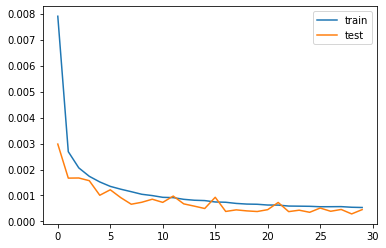

INFO:tensorflow:Assets written to: encoder/assets


In [10]:
""" construct the model """
def autoencoder(n_inputs):
  # input layer 
  input = Input(shape=(n_inputs,))
  # encoder 
  e = Dense(n_inputs*2)(input)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)
  e = Dense(n_inputs)(e)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)
  # bottleneck 
  n_bottleneck = n_inputs
  bottleneck = Dense(n_bottleneck)(e)
  # decoder 
  d = Dense(n_inputs)(bottleneck)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)
  d = Dense(n_inputs*2)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)
  # output 
  output = Dense(n_inputs, activation="linear")(d)
  model = Model(inputs=input, outputs=output)
  model.compile(optimizer="adam", loss="mse")
  # plot model
  plot_model(model, "autoencoder.png", show_shapes=True)
  history = model.fit(X_train, X_train, epochs=30, batch_size=16, verbose=2, validation_data=(X_test,X_test))
  # plot loss
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history["val_loss"], label="test")
  plt.legend()
  plt.show()
  # define an encoder model (without the decoder)
  encoder = Model(inputs=input, outputs=bottleneck)
  plot_model(encoder, "encoder.png", show_shapes=True)
  # save encoder to the file
  encoder.save("encoder")

autoencoder(n_inputs = X_train.shape[1])

In [12]:
""" baseline model as decision tree classifier """
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [13]:
# accuracy
print(f"Accuracy of baseline model (decision tree classifier): {metrics.accuracy_score(y_test, y_hat)}")
# classification report 
print(metrics.classification_report(y_test, y_hat))

Accuracy of baseline model (decision tree classifier): 0.968136123050691
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     27230
         1.0       0.51      0.55      0.53       921

    accuracy                           0.97     28151
   macro avg       0.75      0.76      0.76     28151
weighted avg       0.97      0.97      0.97     28151



In [16]:
""" encoder, decision tree classifier """
encoder = load_model("./encoder/", compile = False)
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
model = DecisionTreeClassifier()
model.fit(X_train_encode, y_train)
y_hat = model.predict(X_test)

In [17]:
""" very poor performance """
# accuracy
print(f"Accuracy of (encoder, decision tree classifier): {metrics.accuracy_score(y_test, y_hat)}")
# classification report 
print(metrics.classification_report(y_test, y_hat))

Accuracy of (encoder, decision tree classifier): 0.9656850555930517
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     27230
         1.0       0.00      0.00      0.00       921

    accuracy                           0.97     28151
   macro avg       0.48      0.50      0.49     28151
weighted avg       0.94      0.97      0.95     28151



In [21]:
""" random forest as baseline model """
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [22]:
# accuracy
print(f"Accuracy of baseline model (random forest classifier): {metrics.accuracy_score(y_test, y_hat)}")
# classification report 
print(metrics.classification_report(y_test, y_hat))

Accuracy of baseline model (random forest classifier): 0.9794323469858974
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     27230
         1.0       0.96      0.39      0.55       921

    accuracy                           0.98     28151
   macro avg       0.97      0.69      0.77     28151
weighted avg       0.98      0.98      0.98     28151



In [ ]:
""" support vector machine as baseline model """
model = SVC(kernel="linear")
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

In [16]:
# accuracy
print(f"Accuracy of baseline model (support vector machine): {metrics.accuracy_score(y_test, y_hat)}")
# classification report 
print(metrics.classification_report(y_test, y_hat))

Accuracy of baseline model (support vector machine): 0.9672835778480339
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     27230
         1.0       0.00      0.00      0.00       921

    accuracy                           0.97     28151
   macro avg       0.48      0.50      0.49     28151
weighted avg       0.94      0.97      0.95     28151



In [ ]:
""" not executable """
model.fit(X_train_encode, y_train)
y_hat = model.predict(X_test_encode)
# accuracy
print(f"Accuracy of (encoder, support vector machine): {metrics.accuracy_score(y_test, y_hat)}")
# classification report 
print(metrics.classification_report(y_test, y_hat))